In [1]:
!pip install transformers
!pip install sympy==1.13.1
!pip install datasets
!pip install scikit-learn
!pip install matplotlib seaborn
!pip install pandas

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import time


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import torch

In [3]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/tweet-sentiment-s-impact-on-stock-returns")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tweet-sentiment-s-impact-on-stock-returns


In [4]:
import os

print(os.listdir(path))  # To see what's in the path file

# Only use the full dataset
csv_path = os.path.join(path, "full_dataset-release.csv")
df_full = pd.read_csv(csv_path, index_col=False)

# csv_path2 = os.path.join(path, "reduced_dataset-release.csv")
# df_red = pd.read_csv(csv_path2, index_col=False)

['full_dataset-release.csv', 'reduced_dataset-release.csv']


In [45]:
print(df_full.shape)
print(df_full.head())
print(df_full.info())

# (1395450, 14)   shape of the full dataset

(367620, 14)
   Unnamed: 0                                              TWEET      STOCK  \
2           1  @FAME95FM1 Jamaicans make money with @Payoneer...     PayPal   
3           2  @CBSi Jamaicans make money with @Payoneer @Pay...     PayPal   
4           3  @Hitz92fm Jamaicans make money with @Payoneer ...     PayPal   
11          7  RT @nikitakhara: Thank you, @Starbucks CEO for...  Starbucks   
20         12  @gawker Jamaicans make money with @Payoneer @P...     PayPal   

          DATE  LAST_PRICE  1_DAY_RETURN  2_DAY_RETURN  3_DAY_RETURN  \
2   31/01/2017       39.78      0.002011      0.012318      0.012318   
3   31/01/2017       39.78      0.002011      0.012318      0.012318   
4   31/01/2017       39.78      0.002011      0.012318      0.012318   
11  31/01/2017       55.22      0.012314      0.016298      0.016298   
20  31/01/2017       39.78      0.002011      0.012318      0.012318   

    7_DAY_RETURN   PX_VOLUME  VOLATILITY_10D  VOLATILITY_30D  LSTM_POLARITY  \


In [6]:
df_full = df_full.dropna()
df_full = df_full.drop_duplicates()

count = df_full['STOCK'].value_counts()
perc = count/count.sum()
dstr = pd.DataFrame({"Count": count, "Percentage": perc}).reset_index()
dstr

STOCK  Count  Percentage
0               Ford  52198    0.141989
1           Facebook  40837    0.111085
2             Google  33697    0.091663
3               Next  32606    0.088695
4              Apple  27940    0.076002
..               ...    ...         ...
96        Volkswagen     18    0.000049
97           Equinor     12    0.000033
98        CVS Health     11    0.000030
99              21CF      4    0.000011
100  Cardinal Health      2    0.000005

[101 rows x 3 columns]

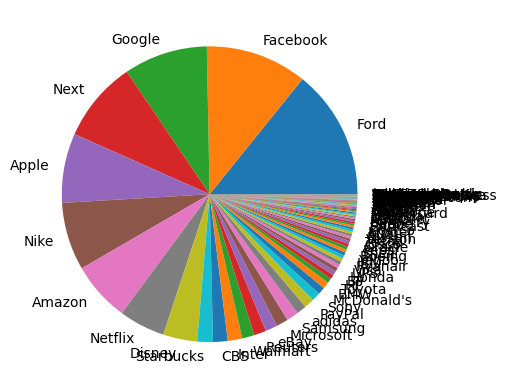

In [7]:
import matplotlib.pyplot as plt
plt.pie(dstr['Count'], labels = dstr['STOCK'])
plt.show()

In [8]:
# Top 5 stocks (~50% share of tweets)
TOP_STOCKS = dstr['STOCK'].head().to_list()

# Middle 25%
MID_STOCKS = dstr['STOCK'].iloc[5:].head().to_list()

# Bottom 25% (Below Starbucks)
BOT_STOCKS = dstr['STOCK'].iloc[10:].to_list()

In [9]:
# COL = ['Ford', 'Facebook', 'Google']
df_top = df_full[df_full['STOCK'].isin(TOP_STOCKS) | df_full['TWEET'].isin(TOP_STOCKS)]
df_top = df_top.reset_index(drop=True)
l1 = len(df_top)
l2 = len(df_top[df_top['Unnamed: 0'].isnull()])
df_top[df_top['Unnamed: 0'].isnull()]
print(f"Expected cleaned df size: {l1 - l2}")

df_mid = df_full[df_full['STOCK'].isin(MID_STOCKS) | df_full['TWEET'].isin(MID_STOCKS)]
df_mid = df_mid.reset_index(drop=True)
l1 = len(df_mid)
l2 = len(df_mid[df_mid['Unnamed: 0'].isnull()])
df_mid[df_mid['Unnamed: 0'].isnull()]
print(f"Expected cleaned df size: {l1 - l2}")

df_bot = df_full[df_full['STOCK'].isin(BOT_STOCKS) | df_full['TWEET'].isin(BOT_STOCKS)]
df_bot = df_bot.reset_index(drop=True)
l1 = len(df_bot)
l2 = len(df_bot[df_bot['Unnamed: 0'].isnull()])
df_bot[df_bot['Unnamed: 0'].isnull()]
print(f"Expected cleaned df size: {l1 - l2}")

Expected cleaned df size: 187278
Expected cleaned df size: 89782
Expected cleaned df size: 90560


In [10]:
print(df_top['STOCK'])

0         Google
1         Google
2          Apple
3           Ford
4         Google
           ...  
187273      Ford
187274    Google
187275    Google
187276      Ford
187277      Next
Name: STOCK, Length: 187278, dtype: object


In [46]:
print(df_mid['STOCK'])

0        Starbucks
1        Starbucks
2           Amazon
3        Starbucks
4           Disney
           ...    
89777    Starbucks
89778       Amazon
89779       Disney
89780       Disney
89781       Disney
Name: STOCK, Length: 89782, dtype: object


In [12]:
print(df_bot['STOCK'])

0         PayPal
1         PayPal
2         PayPal
3         PayPal
4        Reuters
          ...   
90555    Reuters
90556       Visa
90557      Honda
90558     PayPal
90559       Sony
Name: STOCK, Length: 90560, dtype: object


In [13]:
misaligned_rows = df_full[df_full.iloc[:, 0].isna()]
print(f"Misaligned rows: {len(misaligned_rows)} out of {len(df_full)} total")
# before: Misaligned rows: 293437 out of 143282 total
# now weird: Misaligned rows: 0 out of 367620 total

Misaligned rows: 0 out of 367620 total


In [14]:
# Function to fix misalignment
def fix_misalignment(df):
    # Copy the original DataFrame to avoid altering it directly
    df = df.copy()

    # Create a mask where the first column is NaN
    mask = df.iloc[:, 0].isna()

    # Iterate over rows where the mask is True
    for idx in df[mask].index.tolist():  # Use a list of indices to avoid dynamic changes
        # Get the previous row index
        previous_idx = idx - 1

        # Ensure the previous index is valid and within bounds
        if previous_idx in df.index:
            for col in range(1, len(df.columns)):
                # Check if the current value is non-NaN
                if not pd.isna(df.iloc[idx, col]):
                    # Ensure the column is within bounds of the previous row
                    if col+1 < len(df.columns):
                        df.iloc[previous_idx, col+1] = df.iloc[idx, col]

    # Drop rows where the first column is NaN
    df = df[~mask]

    return df

In [15]:
df_full = fix_misalignment(df_full)

# Data Cleaning

In [16]:
df_full_cleaned = df_full.reset_index(drop=True)
df_full_cleaned = df_full_cleaned.drop('Unnamed: 0', axis=1)
df_full_cleaned

TWEET      STOCK  \
0       @FAME95FM1 Jamaicans make money with @Payoneer...     PayPal   
1       @CBSi Jamaicans make money with @Payoneer @Pay...     PayPal   
2       @Hitz92fm Jamaicans make money with @Payoneer ...     PayPal   
3       RT @nikitakhara: Thank you, @Starbucks CEO for...  Starbucks   
4       @gawker Jamaicans make money with @Payoneer @P...     PayPal   
...                                                   ...        ...   
367615  RT @rmbyrne: Do you have any colleagues who th...     Google   
367616  RT @AnnCoulter: Item No. 3 for FBI to investig...       Ford   
367617  RT @radiodisney: Tune in to the Radio Disney I...     Disney   
367618  Rockets Fall at Fresno State, 49-27; Return Ho...       Next   
367619  RT @radiodisney: Tune in to the Radio Disney I...     Disney   

              DATE  LAST_PRICE  1_DAY_RETURN  2_DAY_RETURN  3_DAY_RETURN  \
0       31/01/2017       39.78      0.002011      0.012318      0.012318   
1       31/01/2017       39.78      0.002011      0.012318      0.012318   
2       31/01/2017       39.78      0.002011      0.012318      0.012318   
3       31/01/2017       55.22      0.012314      0.016298      0.016298   
4       31/01/2017       39.78      0.002011      0.012318      0.012318   
...            ...         ...           ...           ...           ...   
367615  30/09/2018     1207.08      0.000000      0.000000      0.000232   
367616  30/09/2018        9.25      0.000000      0.000000     -0.002162   
367617  30/09/2018      116.94      0.000000      0.000000     -0.007696   
367618  30/09/2018     5494.00      0.000000      0.000000     -0.029487   
367619  30/09/2018      116.94      0.000000      0.000000     -0.007696   

        7_DAY_RETURN   PX_VOLUME  VOLATILITY_10D  VOLATILITY_30D  \
0           0.054801   9100057.0          18.769          16.099   
1           0.054801   9100057.0          18.769          16.099   
2           0.054801   9100057.0          18.769          16.099   
3           0.058312  14307985.0          23.916          17.298   
4           0.054801   9100057.0          18.769          16.099   
...              ...         ...             ...             ...   
367615     -0.028962   1780759.0          15.005          17.588   
367616      0.064865  30987233.0          23.492          22.989   
367617     -0.055926   7366846.0          15.232          13.230   
367618     -0.053513    729746.0          51.157          29.383   
367619     -0.055926   7366846.0          15.232          13.230   

        LSTM_POLARITY  TEXTBLOB_POLARITY  
0                -1.0             0.0000  
1                 1.0             0.0000  
2                -1.0             0.0000  
3                 1.0             0.2000  
4                -1.0             0.0000  
...               ...                ...  
367615           -1.0            -0.0625  
367616           -1.0             0.0000  
367617            1.0             0.0000  
367618            1.0             0.0000  
367619            1.0             0.0000  

[367620 rows x 13 columns]

In [17]:
# Dates are non-consecutive outisde of (2018-7-11 to 2018-10-2) so we'll exclude those values
df_full_cleaned['DATE'] = pd.to_datetime(df_full_cleaned['DATE'])

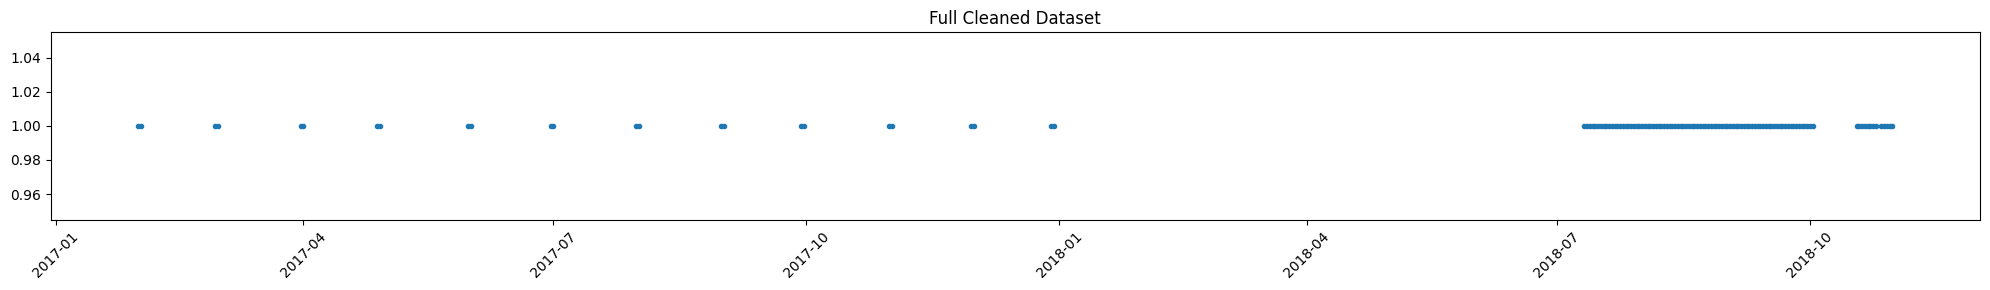

In [18]:
# Dates seems to be non-concsecutive until 2018-7-11
# Visualize dates in the full cleaned dataset
fig, ax = plt.subplots(1, 1, figsize=(20, 3))  # Only 1 plot

dates = df_full_cleaned['DATE'].sort_values().unique()
ax.scatter(x=dates, y=[1]*len(dates), marker='.')
ax.tick_params(axis='x', rotation=45)
ax.set_title("Full Cleaned Dataset")

plt.tight_layout()
plt.show()


In [19]:
# Function to slice dataframe to keep only dates after 2018-7-11
def slice_date(df):
    df = df[(df['DATE'] >= '2018-7-11') & (df['DATE'] <= '2018-10-2')].sort_values(by='DATE')
    df = df.reset_index(drop=True)
    return df

df_full_cleaned = slice_date(df_full_cleaned)

In [20]:
print(df_full_cleaned['STOCK'].unique())

['Apple' 'Netflix' 'Nike' 'Google' 'Kroger' 'HP' 'Disney' 'Next' 'Yahoo'
 'Starbucks' 'Samsung' 'Ford' 'BMW' 'Comcast' 'PayPal' 'Amazon' 'adidas'
 'Facebook' 'Intel' 'Pfizer' 'Walmart' 'BP' 'Verizon' 'eBay' "McDonald's"
 'Ryanair' 'Microsoft' 'Toyota' 'Sony' 'Costco' 'Heineken' 'CBS' 'Honda'
 'Audi' 'Cisco' 'FedEx' 'Reuters' 'Burberry' 'Mastercard' 'IBM' 'Exxon'
 'Gillette' 'Visa' 'Nestle' 'UPS' 'BASF' 'Chevron' 'Siemens' 'ASOS' 'SAP'
 'Pepsi' 'Groupon' 'Nissan' 'Shell' 'Hyundai' 'Tesco' 'Colgate' 'Adobe'
 'Allianz' 'AstraZeneca' 'Vodafone' 'Oracle' 'Bayer' 'Santander'
 'Citigroup' "Kellogg's" 'TripAdvisor' 'JPMorgan' 'CocaCola' 'Boeing'
 'HSBC' 'Carrefour' 'GSK' 'BlackRock' 'Thales' 'Aviva' 'Expedia' 'TMobile'
 'easyJet' 'Danone' 'Viacom' "L'Oreal" 'Equinor' '21CF' 'AT&T'
 'bookingcom' 'Home Depot' 'Morgan Stanley' 'American Express'
 'Bank of America' 'Deutsche Bank' 'Goldman Sachs' 'Wells Fargo'
 'Volkswagen' 'salesforce.com' 'H&M' 'General Electric' 'John Deere' 'P&G'
 'Cardinal He

In [21]:
df_full_cleaned.to_csv('df_full_cleaned.csv', index=False)

In [22]:
print(df_full_cleaned.shape)
print(df_full_cleaned.columns)
# shape: (280785, 13)

(280785, 13)
Index(['TWEET', 'STOCK', 'DATE', 'LAST_PRICE', '1_DAY_RETURN', '2_DAY_RETURN',
       '3_DAY_RETURN', '7_DAY_RETURN', 'PX_VOLUME', 'VOLATILITY_10D',
       'VOLATILITY_30D', 'LSTM_POLARITY', 'TEXTBLOB_POLARITY'],
      dtype='object')


In [23]:
def group_df(df):
    df_grouped = df.groupby(['STOCK', 'DATE'], as_index=False).agg({'LSTM_POLARITY':'sum', '1_DAY_RETURN':'mean', 'PX_VOLUME':'mean', 'VOLATILITY_10D':'mean'}).reset_index(drop=True)
    return df_grouped

In [24]:
df_full_final = group_df(df_full_cleaned)

In [25]:
print(df_full_final.shape)
print(df_full_final.head())
print(df_full_final.columns)
# cols: STOCK DATE  LSTM_POLARITY  1_DAY_RETURN  PX_VOLUME  VOLATILITY_10D

(5734, 6)
  STOCK       DATE  LSTM_POLARITY  1_DAY_RETURN  PX_VOLUME  VOLATILITY_10D
0  21CF 2018-08-10            1.0      0.002639  5206734.0           7.018
1  21CF 2018-09-05            0.0      0.001547  7801635.0           6.489
2  ASOS 2018-07-11           -1.0      0.008923   217525.0          24.907
3  ASOS 2018-07-15           -2.0      0.000000   846417.0          67.943
4  ASOS 2018-07-17           -1.0     -0.045575   678881.0          72.684
Index(['STOCK', 'DATE', 'LSTM_POLARITY', '1_DAY_RETURN', 'PX_VOLUME',
       'VOLATILITY_10D'],
      dtype='object')


In [26]:
# Fix misalighments on top, mid, bot stocks
df_bot_cleaned = fix_misalignment(df_bot)
df_mid_cleaned = fix_misalignment(df_mid)
df_top_cleaned = fix_misalignment(df_top)

In [27]:
df_top_cleaned = df_top.reset_index(drop=True)
df_top_cleaned = df_top.drop('Unnamed: 0', axis=1)
df_top_cleaned

TWEET   STOCK        DATE  \
0       RT @IndiaHistorypic: 1994::Young @sundarpichai...  Google  31/01/2017   
1       RT @Google: "If you have the feeling that some...  Google  31/01/2017   
2       RT @IBMWatson: Welcome @Apple, #ACLU, #AAAI, @...   Apple  31/01/2017   
3       RT @ColMorrisDavis: My family owned a @Ford de...    Ford  31/01/2017   
4       RT @ThatBitchFromNJ: Google's sponsored ad for...  Google  31/01/2017   
...                                                   ...     ...         ...   
187273  RT @time2trade2: @McAllisterDen Trump called f...    Ford  30/09/2018   
187274  Thanks Google\r\r\r\r\r\r\n\r\r\r\r\r\r\nHey L...  Google  30/09/2018   
187275  RT @rmbyrne: Do you have any colleagues who th...  Google  30/09/2018   
187276  RT @AnnCoulter: Item No. 3 for FBI to investig...    Ford  30/09/2018   
187277  Rockets Fall at Fresno State, 49-27; Return Ho...    Next  30/09/2018   

        LAST_PRICE  1_DAY_RETURN  2_DAY_RETURN  3_DAY_RETURN  7_DAY_RETURN  \
0           820.19      0.004438      0.030286      0.030286      0.035772   
1           820.19      0.004438      0.030286      0.030286      0.035772   
2           121.35      0.002307      0.004944      0.004944     -0.011372   
3            12.36      0.000809      0.010518      0.010518      0.020227   
4           820.19      0.004438      0.030286      0.030286      0.035772   
...            ...           ...           ...           ...           ...   
187273        9.25      0.000000      0.000000     -0.002162      0.064865   
187274     1207.08      0.000000      0.000000      0.000232     -0.028962   
187275     1207.08      0.000000      0.000000      0.000232     -0.028962   
187276        9.25      0.000000      0.000000     -0.002162      0.064865   
187277     5494.00      0.000000      0.000000     -0.029487     -0.053513   

         PX_VOLUME  VOLATILITY_10D  VOLATILITY_30D  LSTM_POLARITY  \
0        2020180.0          21.549          14.953           -1.0   
1        2020180.0          21.549          14.953           -1.0   
2       49200993.0           9.114           8.417            1.0   
3       46974479.0          26.321          27.647            1.0   
4        2020180.0          21.549          14.953           -1.0   
...            ...             ...             ...            ...   
187273  30987233.0          23.492          22.989            1.0   
187274   1780759.0          15.005          17.588            1.0   
187275   1780759.0          15.005          17.588           -1.0   
187276  30987233.0          23.492          22.989           -1.0   
187277    729746.0          51.157          29.383            1.0   

        TEXTBLOB_POLARITY  
0                  0.0000  
1                 -0.5500  
2                  1.0000  
3                  0.0000  
4                 -0.1000  
...                   ...  
187273             0.0000  
187274             0.2000  
187275            -0.0625  
187276             0.0000  
187277             0.0000  

[187278 rows x 13 columns]

In [28]:
df_mid_cleaned = df_mid_cleaned.reset_index(drop=True)
df_mid_cleaned = df_mid_cleaned.drop('Unnamed: 0', axis=1)
df_mid_cleaned

TWEET      STOCK  \
0      RT @nikitakhara: Thank you, @Starbucks CEO for...  Starbucks   
1      RT @cultcommoncore: Dumping @Starbucks\r\r\r\r...  Starbucks   
2      @amazon has your back when it comes to food sh...     Amazon   
3      RT @nia4_trump: So instead of hiring 10,000 un...  Starbucks   
4      Hmmm interesting... \r\r\r\r\r\r\nonly @IBM ha...     Disney   
...                                                  ...        ...   
89777  I'm at Starbucks in Al-Andalus, Al Asimah http...  Starbucks   
89778  RT @suzford: This bodes well! #JulieRapaport n...     Amazon   
89779  RT @shopWSS: Celebrating 90 years of Mickey Mo...     Disney   
89780  RT @radiodisney: Tune in to the Radio Disney I...     Disney   
89781  RT @radiodisney: Tune in to the Radio Disney I...     Disney   

             DATE  LAST_PRICE  1_DAY_RETURN  2_DAY_RETURN  3_DAY_RETURN  \
0      31/01/2017       55.22      0.012314      0.016298      0.016298   
1      31/01/2017       55.22      0.012314      0.016298      0.016298   
2      31/01/2017      823.48      0.008379      0.014924      0.014924   
3      31/01/2017       55.22      0.012314      0.016298      0.016298   
4      31/01/2017      110.65      0.002621     -0.012201     -0.012201   
...           ...         ...           ...           ...           ...   
89777  30/09/2018       56.84      0.000000      0.000000      0.008797   
89778  30/09/2018     2003.00      0.000000      0.000000      0.004983   
89779  30/09/2018      116.94      0.000000      0.000000     -0.007696   
89780  30/09/2018      116.94      0.000000      0.000000     -0.007696   
89781  30/09/2018      116.94      0.000000      0.000000     -0.007696   

       7_DAY_RETURN   PX_VOLUME  VOLATILITY_10D  VOLATILITY_30D  \
0          0.058312  14307985.0          23.916          17.298   
1          0.058312  14307985.0          23.916          17.298   
2         -0.001263   3137196.0          13.447          16.992   
3          0.058312  14307985.0          23.916          17.298   
4         -0.024853   8485838.0          12.229          12.982   
...             ...         ...             ...             ...   
89777      0.010732   8975955.0          17.035          13.123   
89778     -0.043929   4085135.0          20.709          22.946   
89779     -0.055926   7366846.0          15.232          13.230   
89780     -0.055926   7366846.0          15.232          13.230   
89781     -0.055926   7366846.0          15.232          13.230   

       LSTM_POLARITY  TEXTBLOB_POLARITY  
0                1.0               0.20  
1               -1.0               0.00  
2               -1.0               0.00  
3               -1.0               0.00  
4               -1.0               0.25  
...              ...                ...  
89777           -1.0               0.00  
89778            1.0               0.00  
89779            1.0               0.00  
89780            1.0               0.00  
89781            1.0               0.00  

[89782 rows x 13 columns]

In [29]:
df_bot_cleaned = df_bot_cleaned.reset_index(drop=True)
df_bot_cleaned = df_bot_cleaned.drop('Unnamed: 0', axis=1)
df_bot_cleaned

TWEET    STOCK        DATE  \
0      @FAME95FM1 Jamaicans make money with @Payoneer...   PayPal  31/01/2017   
1      @CBSi Jamaicans make money with @Payoneer @Pay...   PayPal  31/01/2017   
2      @Hitz92fm Jamaicans make money with @Payoneer ...   PayPal  31/01/2017   
3      @gawker Jamaicans make money with @Payoneer @P...   PayPal  31/01/2017   
4      @Dal_Schnur @DKuzLA @wrightco0704 @psuba98 @Re...  Reuters  31/01/2017   
...                                                  ...      ...         ...   
90555  RT @SyriaArchivist: @ReutersWorld How about Re...  Reuters  30/09/2018   
90556  24 Destinations Where You Can Stay\r\r\r\r\r\r...     Visa  30/09/2018   
90557  RT @DrKanyuira: In Japan,  youths in their mid...    Honda  30/09/2018   
90558  RT @Spicywienerprod: The #sexy Roxy Cox  Follo...   PayPal  30/09/2018   
90559  @KapilSharmaK9 \r\r\r\r\r\r\nWas watching your...     Sony  30/09/2018   

       LAST_PRICE  1_DAY_RETURN  2_DAY_RETURN  3_DAY_RETURN  7_DAY_RETURN  \
0         39.7800      0.002011      0.012318      0.012318      0.054801   
1         39.7800      0.002011      0.012318      0.012318      0.054801   
2         39.7800      0.002011      0.012318      0.012318      0.054801   
3         39.7800      0.002011      0.012318      0.012318      0.054801   
4         49.3887     -0.002677      0.003122      0.003122      0.004461   
...           ...           ...           ...           ...           ...   
90555     50.3139      0.000000      0.000000      0.000876     -0.006785   
90556    150.0900      0.000000      0.000000     -0.000466     -0.000267   
90557   3439.0000      0.000000      0.000000     -0.009305      0.015121   
90558     87.8400      0.000000      0.000000      0.013092      0.031648   
90559   6966.0000      0.000000      0.000000     -0.043210     -0.074935   

        PX_VOLUME  VOLATILITY_10D  VOLATILITY_30D  LSTM_POLARITY  \
0       9100057.0          18.769          16.099           -1.0   
1       9100057.0          18.769          16.099            1.0   
2       9100057.0          18.769          16.099           -1.0   
3       9100057.0          18.769          16.099           -1.0   
4        547029.0           9.665           9.094            1.0   
...           ...             ...             ...            ...   
90555   7988967.0           6.838          12.771            1.0   
90556   6035936.0           9.555          15.939            1.0   
90557   5554600.0          26.410          22.868           -1.0   
90558   7920916.0          15.754          23.131           -1.0   
90559  10999200.0          39.149          24.595            1.0   

       TEXTBLOB_POLARITY  
0               0.000000  
1               0.000000  
2               0.000000  
3               0.000000  
4               0.000000  
...                  ...  
90555           0.350000  
90556           0.500000  
90557          -0.063889  
90558           0.136364  
90559           0.000000  

[90560 rows x 13 columns]

In [30]:
# Dates are non-consecutive outisde of (2018-7-11 to 2018-10-2) so we'll exclude those values
df_top_cleaned['DATE'] = pd.to_datetime(df_top_cleaned['DATE'])
df_mid_cleaned['DATE'] = pd.to_datetime(df_mid_cleaned['DATE'])
df_bot_cleaned['DATE'] = pd.to_datetime(df_bot_cleaned['DATE'])


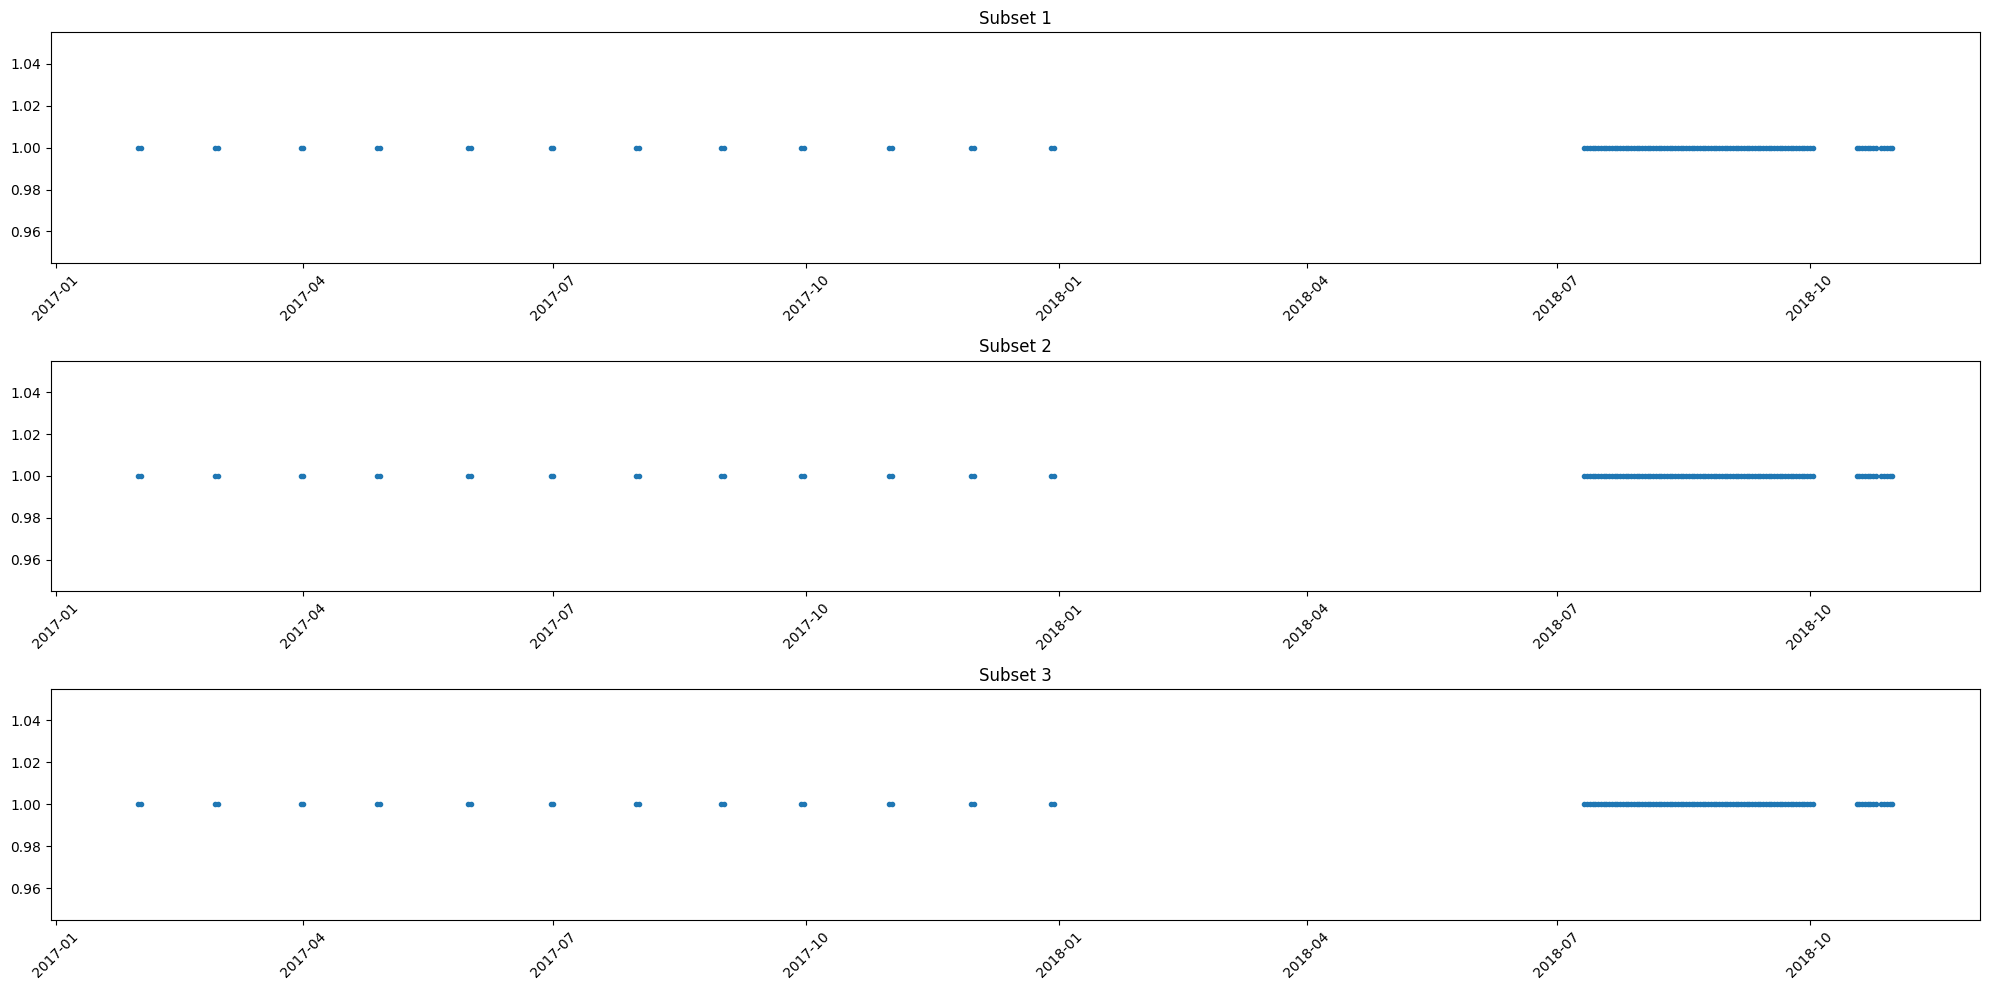

In [31]:
# Dates seems to be non-concsecutive until 2018-7-11
fig, ax, = plt.subplots(3, 1, figsize=(20, 10))
id=0
for df in [df_top_cleaned, df_mid_cleaned, df_bot_cleaned]:
    dates = df['DATE'].sort_values().unique()
    ax[id].scatter(x=dates, y=[1]*len(dates), marker='.')
    ax[id].tick_params(axis='x', rotation=45)
    ax[id].set_title(f"Subset {id + 1}")
    id += 1
plt.tight_layout()
plt.show()

In [32]:
# Function to slice dataframe to keep only dates after 2018-7-11
def slice_date(df):
    df = df[(df['DATE'] >= '2018-7-11') & (df['DATE'] <= '2018-10-2')].sort_values(by='DATE')
    df = df.reset_index(drop=True)
    return df

df_top_cleaned = slice_date(df_top_cleaned)
df_mid_cleaned = slice_date(df_mid_cleaned)
df_bot_cleaned = slice_date(df_bot_cleaned)

In [33]:
print(df_top_cleaned.shape)
print(df_mid_cleaned.shape)
print(df_bot_cleaned.shape)
print(df_top_cleaned.columns)

(148883, 13)
(71025, 13)
(60877, 13)
Index(['TWEET', 'STOCK', 'DATE', 'LAST_PRICE', '1_DAY_RETURN', '2_DAY_RETURN',
       '3_DAY_RETURN', '7_DAY_RETURN', 'PX_VOLUME', 'VOLATILITY_10D',
       'VOLATILITY_30D', 'LSTM_POLARITY', 'TEXTBLOB_POLARITY'],
      dtype='object')


In [34]:
# Save cleaned versions of top, bot, mid stocks
df_top_cleaned.to_csv('df_top_cleaned.csv', index=False)
df_mid_cleaned.to_csv('df_mid_cleaned.csv', index=False)
df_bot_cleaned.to_csv('df_bot_cleaned.csv', index=False)

In [35]:
print(df_top_cleaned.isnull().sum())
print(df_mid_cleaned.isnull().sum())
print(df_bot_cleaned.isnull().sum())
df_bot_cleaned = df_bot_cleaned.dropna() # ok since we're only dropping 1 row

TWEET                0
STOCK                0
DATE                 0
LAST_PRICE           0
1_DAY_RETURN         0
2_DAY_RETURN         0
3_DAY_RETURN         0
7_DAY_RETURN         0
PX_VOLUME            0
VOLATILITY_10D       0
VOLATILITY_30D       0
LSTM_POLARITY        0
TEXTBLOB_POLARITY    0
dtype: int64
TWEET                0
STOCK                0
DATE                 0
LAST_PRICE           0
1_DAY_RETURN         0
2_DAY_RETURN         0
3_DAY_RETURN         0
7_DAY_RETURN         0
PX_VOLUME            0
VOLATILITY_10D       0
VOLATILITY_30D       0
LSTM_POLARITY        0
TEXTBLOB_POLARITY    0
dtype: int64
TWEET                0
STOCK                0
DATE                 0
LAST_PRICE           0
1_DAY_RETURN         0
2_DAY_RETURN         0
3_DAY_RETURN         0
7_DAY_RETURN         0
PX_VOLUME            0
VOLATILITY_10D       0
VOLATILITY_30D       0
LSTM_POLARITY        0
TEXTBLOB_POLARITY    0
dtype: int64


In [47]:
print(df_top_cleaned['STOCK'].unique())
print(df_mid_cleaned['STOCK'].unique())
print(df_bot_cleaned['STOCK'].unique())

['Google' 'Facebook' 'Ford' 'Apple' 'Next']
['Amazon' 'Netflix' 'Nike' 'Disney' 'Starbucks']
['Visa' 'BMW' 'Comcast' 'PayPal' 'adidas' 'Microsoft' 'HP' 'Yahoo'
 'Samsung' 'Pfizer' 'Kroger' 'Ryanair' 'Verizon' 'eBay' "McDonald's"
 'Toyota' 'Walmart' 'BP' 'Sony' 'Intel' 'Cisco' 'CBS' 'Honda' 'Costco'
 'FedEx' 'Reuters' 'Burberry' 'Mastercard' 'IBM' 'Exxon' 'Gillette' 'Audi'
 'Heineken' 'Nestle' 'UPS' 'Siemens' 'BASF' 'Chevron' 'SAP' 'ASOS' 'Pepsi'
 'Nissan' 'Groupon' 'Shell' 'Hyundai' 'Colgate' 'Tesco' 'Adobe' 'Allianz'
 'Citigroup' 'Oracle' 'Bayer' "Kellogg's" 'Carrefour' 'Santander'
 'TripAdvisor' 'JPMorgan' 'CocaCola' 'Vodafone' 'Boeing' 'HSBC'
 'AstraZeneca' 'GSK' 'BlackRock' 'Thales' 'Aviva' 'Expedia' 'TMobile'
 'easyJet' 'Danone' 'Viacom' "L'Oreal" 'Equinor' '21CF' 'AT&T'
 'Bank of America' 'American Express' 'Home Depot' 'bookingcom'
 'Morgan Stanley' 'salesforce.com' 'Volkswagen' 'Goldman Sachs'
 'Deutsche Bank' 'Wells Fargo' 'H&M' 'General Electric' 'P&G' 'John Deere'
 'Cardinal

In [37]:
df_top_final = group_df(df_top_cleaned)
df_mid_final = group_df(df_mid_cleaned)
df_bot_final = group_df(df_bot_cleaned)

In [38]:
print(df_top_final.shape)
print(df_mid_final.shape)
print(df_bot_final.shape)
print(df_top_final.head())
print(df_mid_final.head())
print(df_bot_final.head())

(420, 6)
(420, 6)
(4894, 6)
   STOCK       DATE  LSTM_POLARITY  1_DAY_RETURN   PX_VOLUME  VOLATILITY_10D
0  Apple 2018-07-11           77.0      0.013147  18831470.0          18.568
1  Apple 2018-07-12           61.0     -0.016490  18041131.0          20.021
2  Apple 2018-07-13            2.0     -0.001568  12519792.0          19.797
3  Apple 2018-07-14           -5.0      0.000000  12519792.0          19.797
4  Apple 2018-07-15          -19.0      0.000000  12519792.0          19.797
    STOCK       DATE  LSTM_POLARITY  1_DAY_RETURN  PX_VOLUME  VOLATILITY_10D
0  Amazon 2018-07-11           35.0     -0.006798  3209782.0          16.439
1  Amazon 2018-07-12            7.0     -0.023166  4532743.0          16.113
2  Amazon 2018-07-13            0.0     -0.009051  4386679.0          15.588
3  Amazon 2018-07-14           -1.0      0.000000  4386679.0          15.588
4  Amazon 2018-07-15            4.0      0.000000  4386679.0          15.588
  STOCK       DATE  LSTM_POLARITY  1_DAY_RETURN 

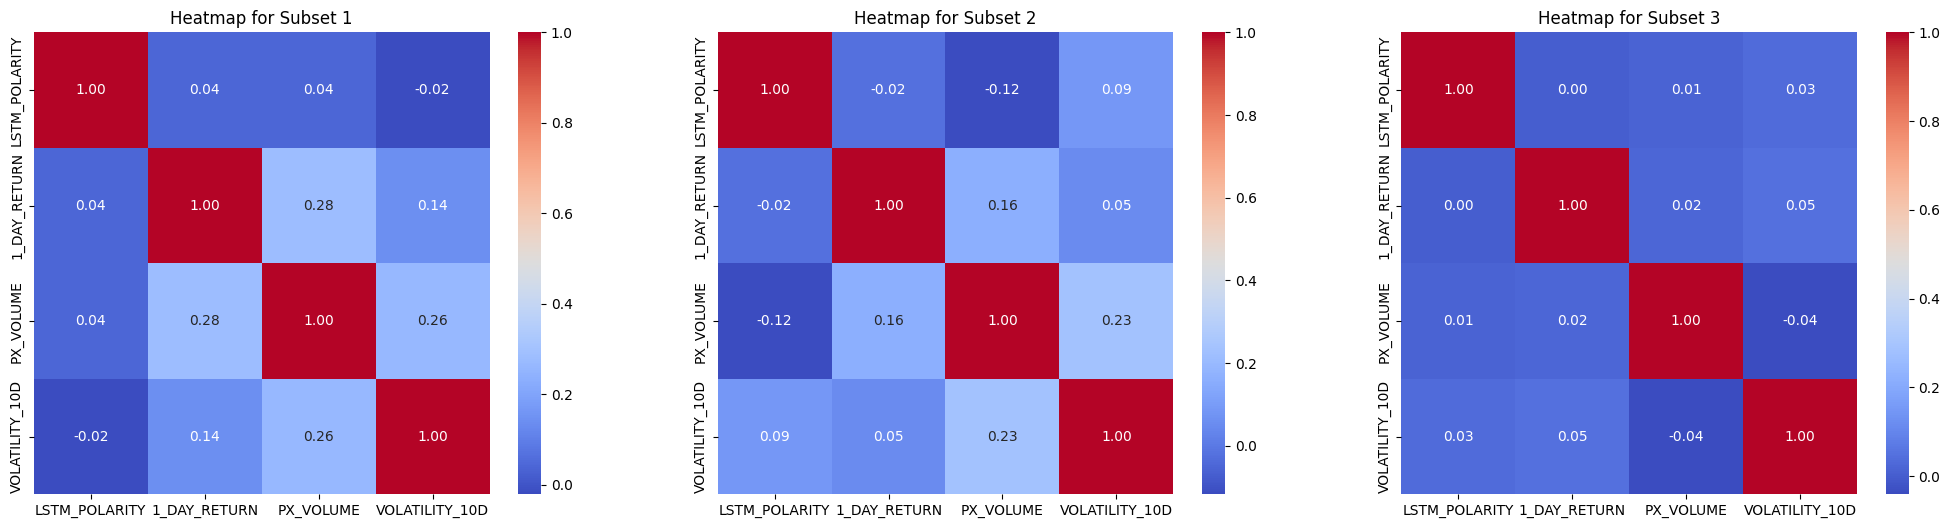

In [39]:
# Create Heatmaps
fig, axes = plt.subplots(1, 3, figsize=(25, 6))
idx = 0

for df in [df_top_final, df_mid_final, df_bot_final]:

    # Feature correlation and relationship
    VAR = df.iloc[:, 2:]

    correlation_matrix = VAR.corr()

    sns.heatmap(correlation_matrix, ax=axes[idx], cmap="coolwarm", fmt=".2f", annot=True)
    axes[idx].set_title(f"Heatmap for Subset {idx+1}")
    idx+=1

plt.show()

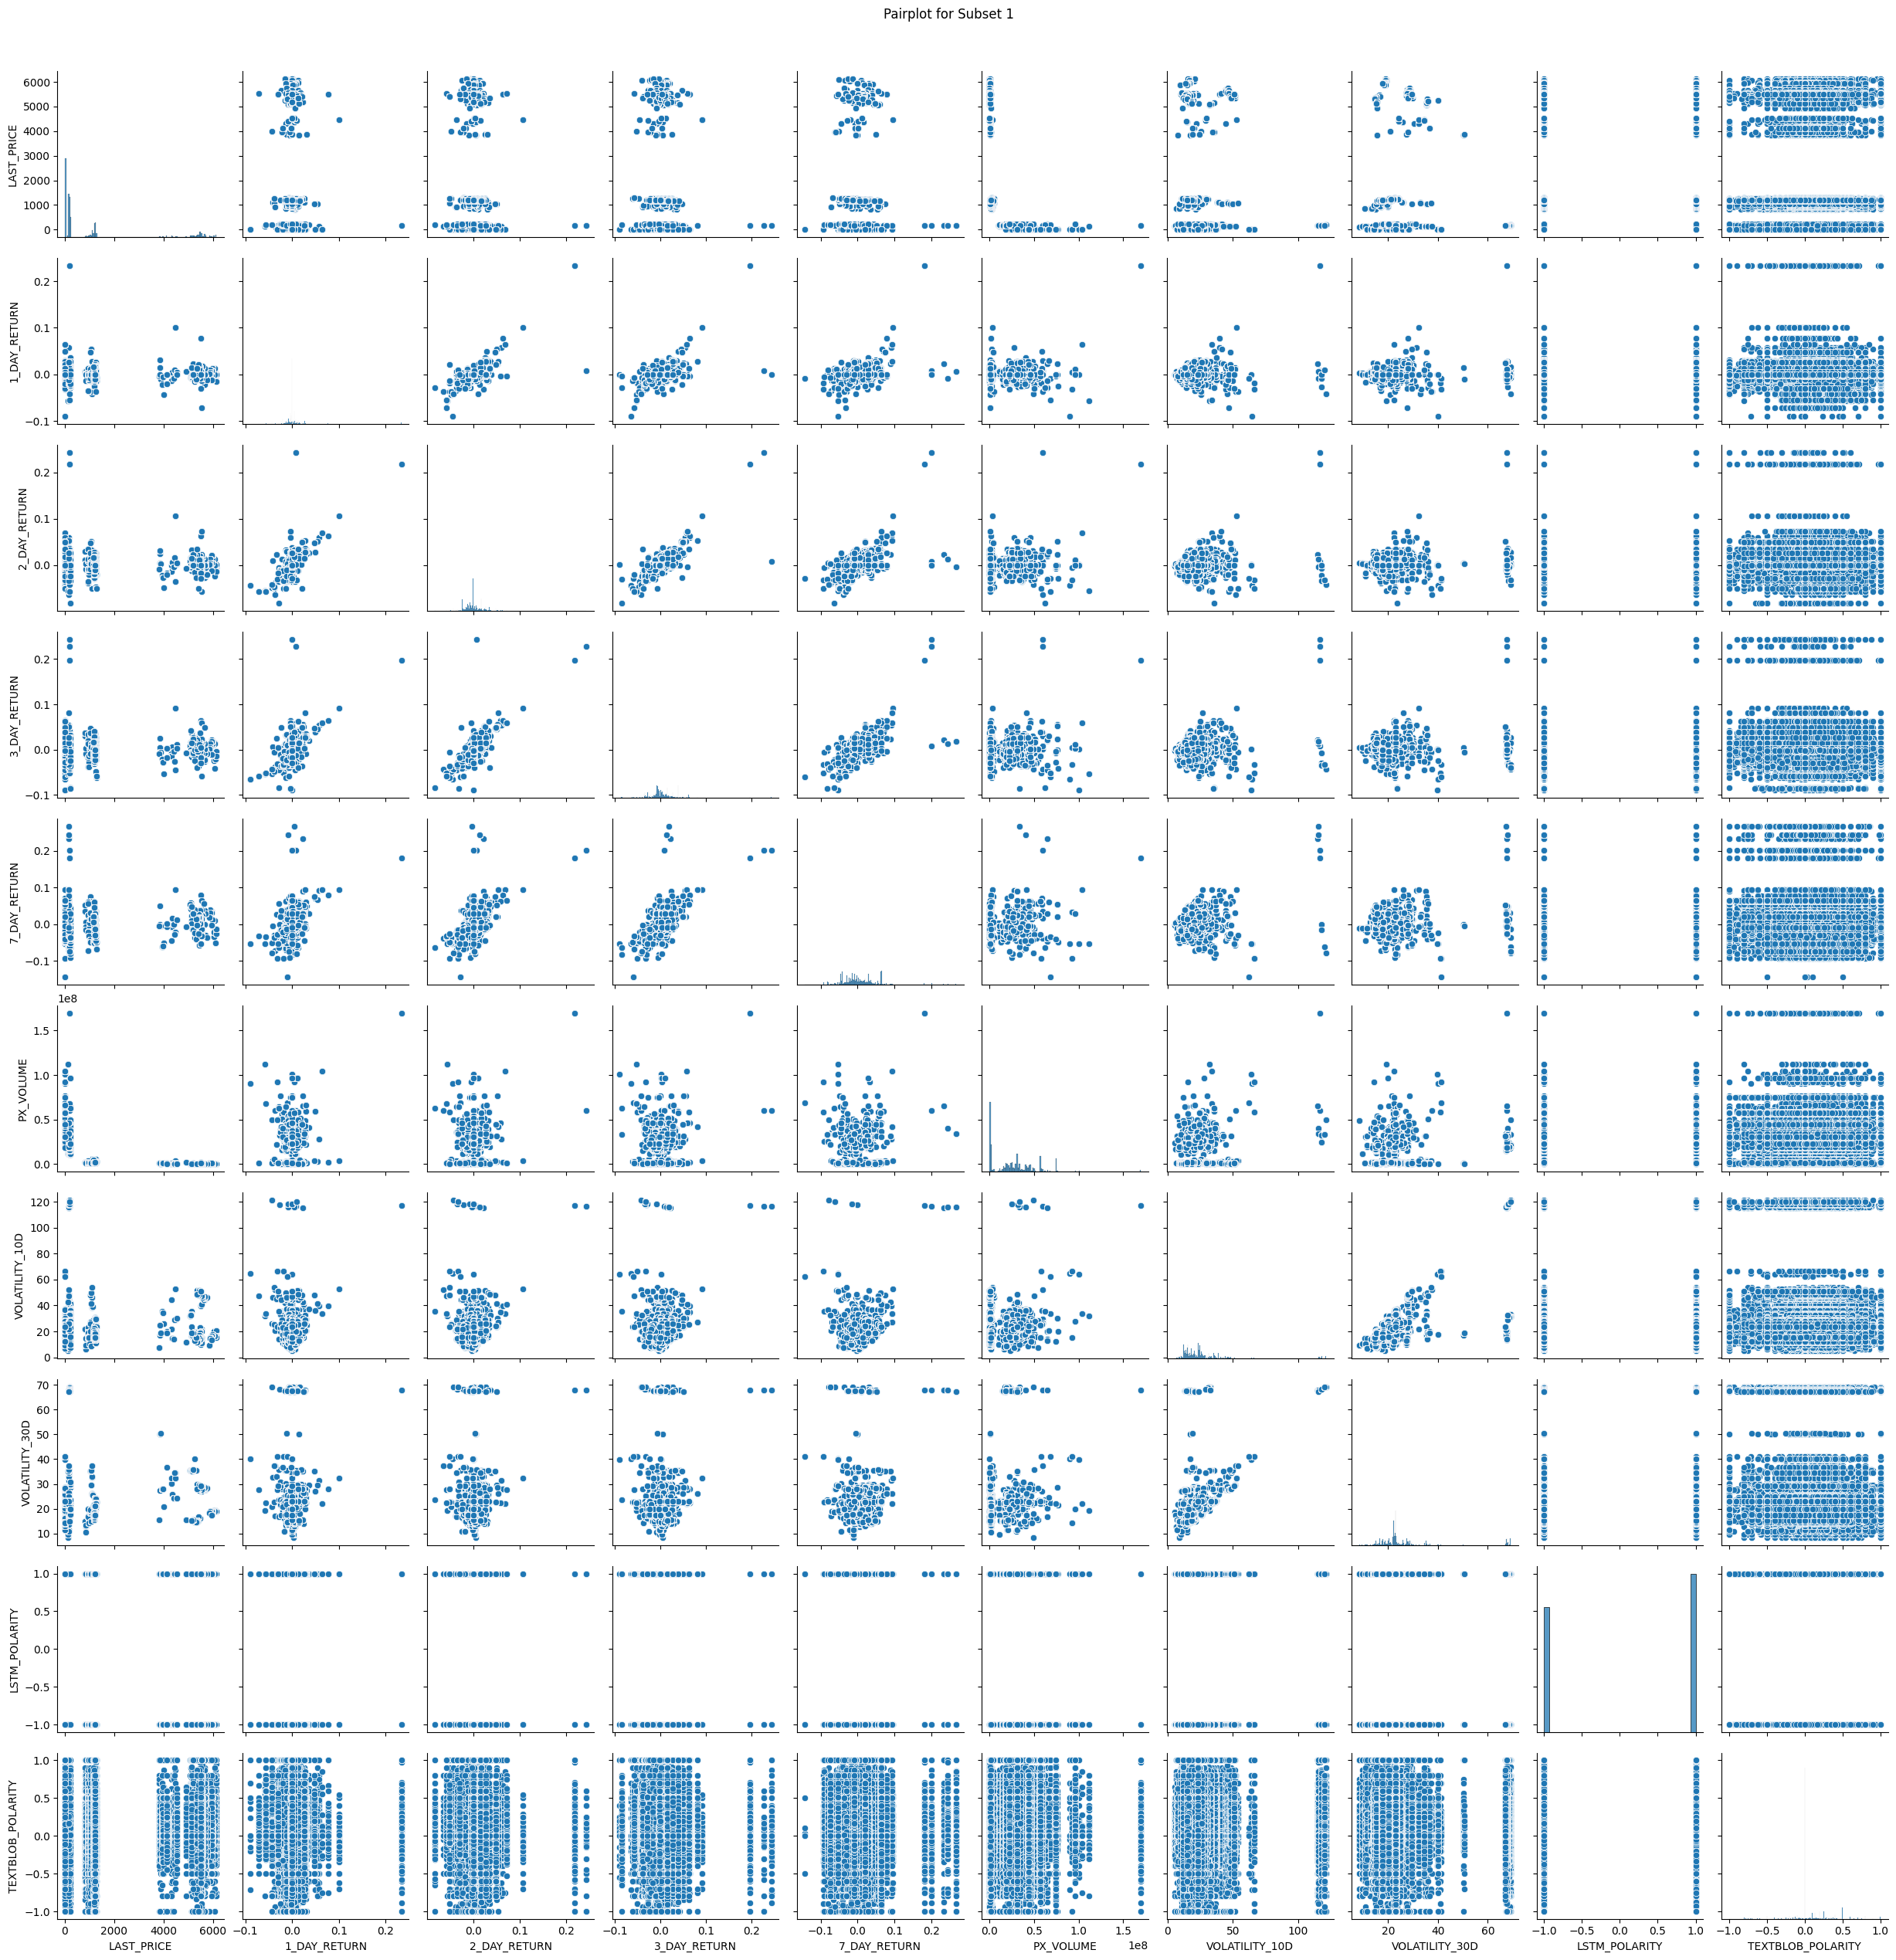

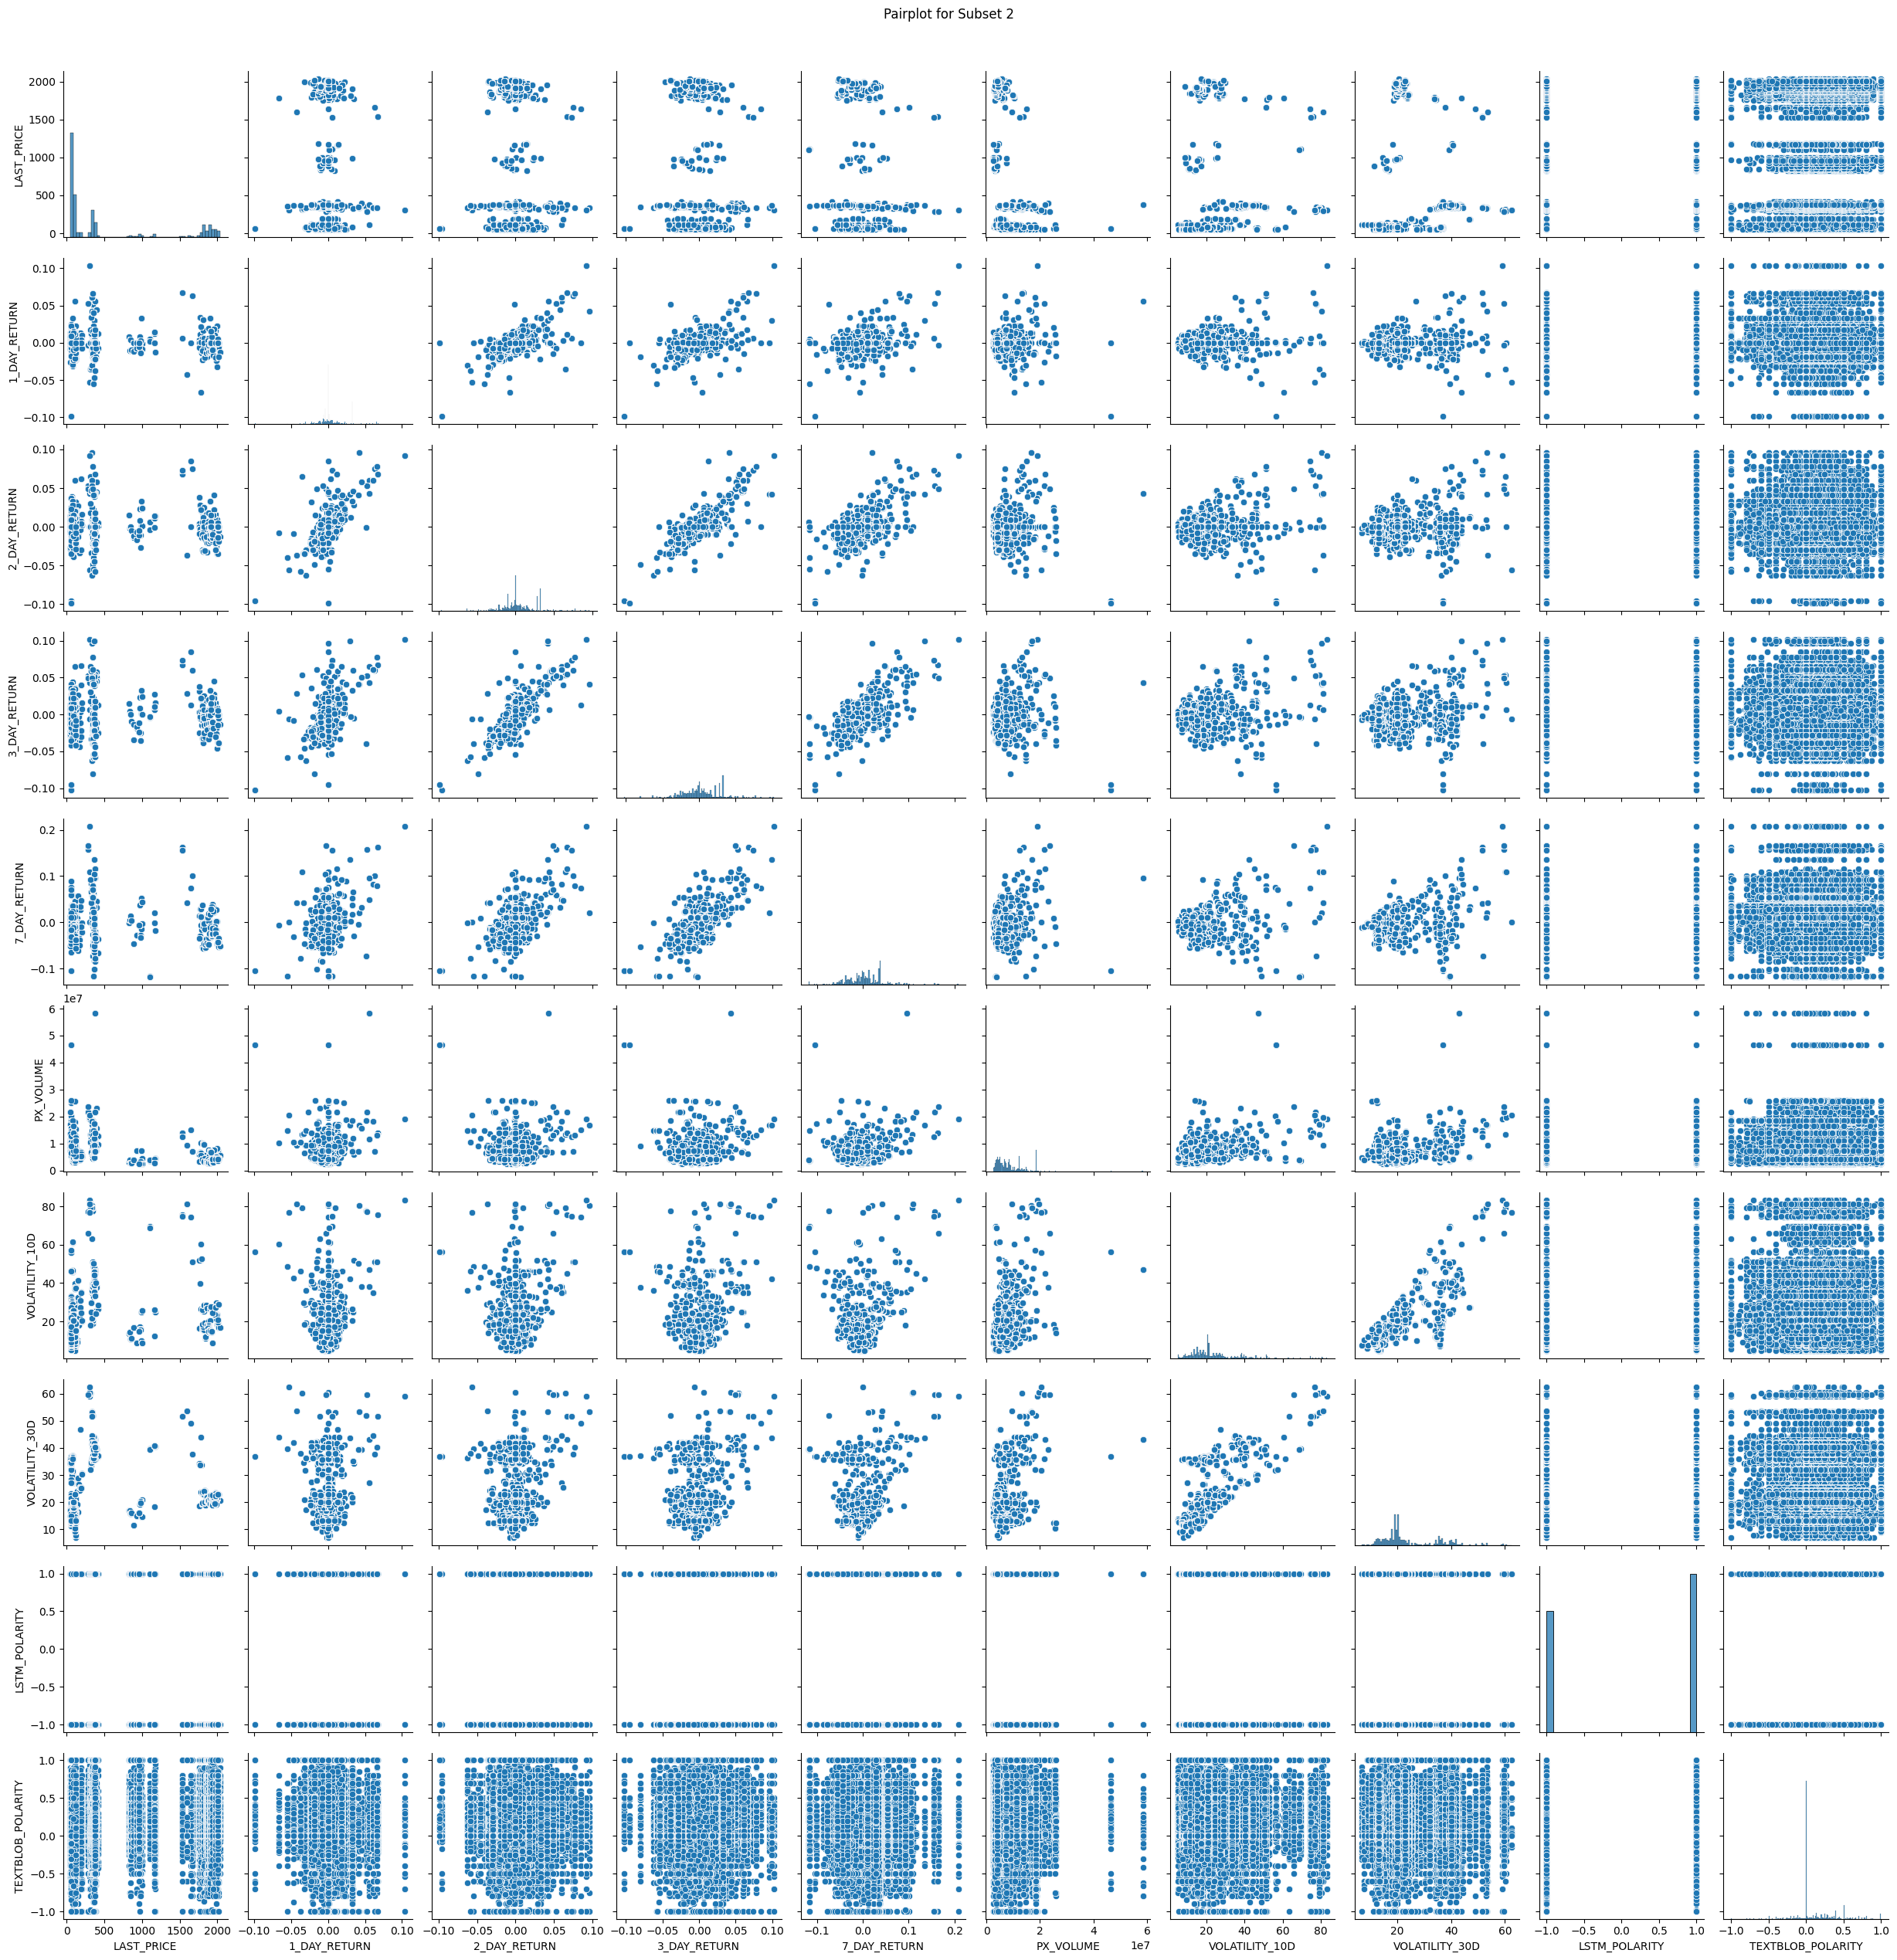

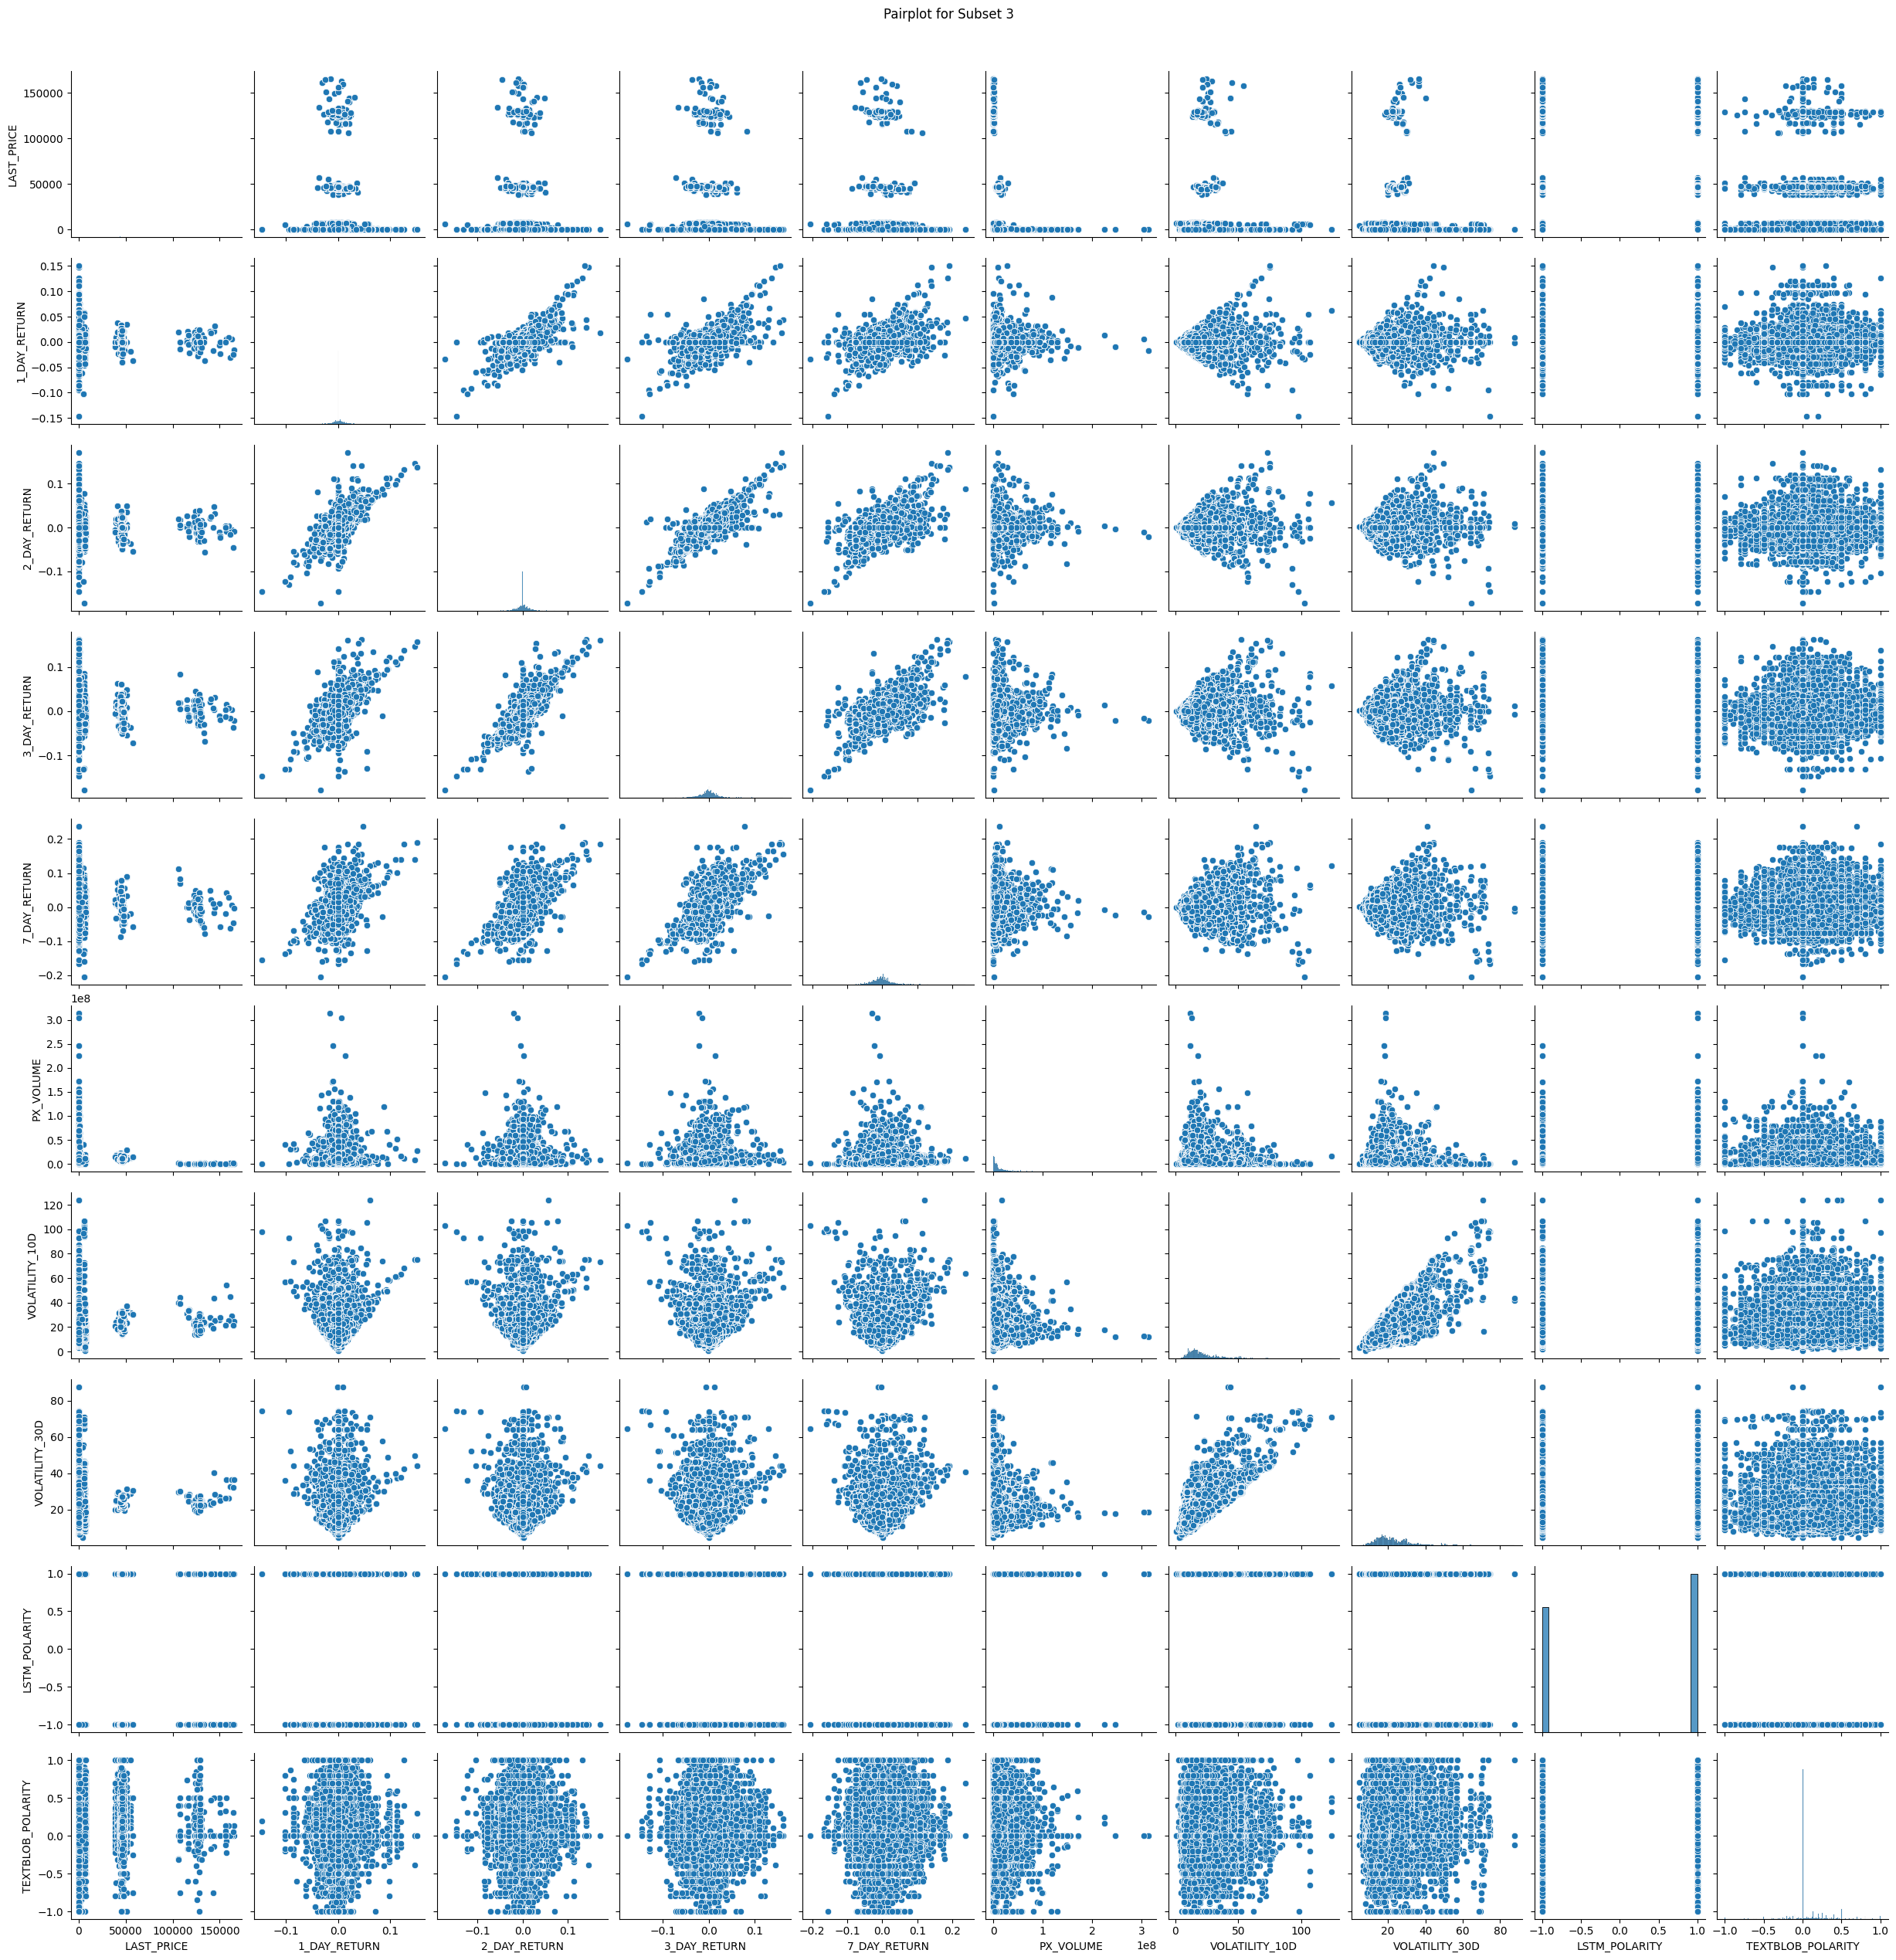

In [40]:
# Create pairplots
# fig, axes = plt.subplots(1, 3, figsize=(25, 6))
idx = 0

for df in [df_top, df_mid, df_bot]:

    # Feature correlation and relationship
    VAR = df.iloc[:, 2:]

    sns.pairplot(VAR)
    # axes[idx].set_title(f"Pairplot for df {idx+1}")
    plt.suptitle(f"Pairplot for Subset {idx+1}", y=1.02)
    idx+=1
    plt.show()

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import RobertaTokenizer, RobertaModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import numpy as np
import time

# 1. Load and preprocess data

# Assume df_full_cleaned is already defined and loaded in your environment
# For demonstration, let's create a dummy df_full_cleaned if it's not present
try:
    df_full_cleaned
except NameError:
    import pandas as pd
    print("[INFO] Creating a dummy df_full_cleaned for demonstration.")
    # Create dummy data that somewhat resembles the expected structure
    data = {
        'TWEET': ["This is a positive tweet about stocks.",
                  "Market is down, feeling negative.",
                  "Good news for investors today!",
                  "Economy is stable, slow growth.",
                  "Bearish sentiment dominating the market.",
                  "Excited about the future of tech stocks.",
                  "Recession fears are growing.",
                  "Company earnings beat expectations.",
                  "Inflation concerns are rising.",
                  "Optimistic outlook for next quarter."] * 30, # Repeat to get 300 entries
        'LSTM_POLARITY': np.random.rand(300) * 2 - 1, # -1 to 1
        '7_DAY_RETURN': np.random.randn(300) * 0.02 + 0.005, # Centered slightly positive
        'PX_VOLUME': np.random.randint(100000, 10000000, 300),
        'VOLATILITY_10D': np.random.rand(300) * 0.05
    }
    df_full_cleaned = pd.DataFrame(data)
    # Ensure some negative returns to create class 0 for target
    df_full_cleaned.loc[df_full_cleaned.sample(frac=0.3).index, '7_DAY_RETURN'] = -np.abs(df_full_cleaned['7_DAY_RETURN'])


df = df_full_cleaned.copy()
df = df.head(300)  # TEMP subset - not needed! REMOVE THIS LINE FOR FULL DATASET TRAINING!

text_data = df['TWEET'].tolist()
target = df['7_DAY_RETURN'].apply(lambda x: 1 if x > 0 else 0).values
print("Target distribution:", Counter(target))

# Numeric features - FIX: REMOVED '7_DAY_RETURN' TO PREVENT DATA LEAKAGE
numeric_data = df[['LSTM_POLARITY', 'PX_VOLUME', 'VOLATILITY_10D']].values # FIXED LINE
scaler = StandardScaler()
numeric_data = scaler.fit_transform(numeric_data)

# Reshape numeric data into sequence format for LSTM: [N, num_features, 1]
# num_features will now be 3 instead of 4
numeric_seq = numeric_data.reshape((numeric_data.shape[0], numeric_data.shape[1], 1))


# 2. Generate RoBERTa embeddings
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta = RobertaModel.from_pretrained("roberta-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
roberta.to(device)
roberta.eval()

@torch.no_grad()
def get_roberta_embeddings(texts, tokenizer, model, batch_size=16):
    all_embeddings = []
    # To prevent long runtime for large datasets during debugging,
    # you might add a limit here if necessary.
    # For df.head(300), this is fine.
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu()
        all_embeddings.append(cls_embeddings)
        # print(f"[DEBUG] Processed batch {i//batch_size + 1}/{len(texts)//batch_size + 1}") # More detailed debug
    return torch.cat(all_embeddings, dim=0)

print("[INFO] Generating RoBERTa embeddings...")
start = time.time()
text_embeddings = get_roberta_embeddings(text_data, tokenizer, roberta)
print(f"[INFO] Embedding time: {time.time() - start:.2f} seconds")


# 3. Convert to Tensors

text_tensor = text_embeddings  # [N, 768]
numeric_seq_tensor = torch.tensor(numeric_seq, dtype=torch.float32)  # [N, num_features, 1]
label_tensor = torch.tensor(target, dtype=torch.float32)  # [N]


# 4. Dataset & Dataloaders
class HybridDataset(Dataset):
    def __init__(self, text_embeddings, numeric_sequences, labels):
        self.text_embeddings = text_embeddings
        self.numeric_sequences = numeric_sequences
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.text_embeddings[idx], self.numeric_sequences[idx], self.labels[idx]

dataset = HybridDataset(text_tensor, numeric_seq_tensor, label_tensor)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


# 5. Define Hybrid Model
class HybridRobertaLSTMModel(nn.Module):
    def __init__(self, roberta_dim, lstm_input_size, lstm_hidden_size, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=lstm_hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(roberta_dim + lstm_hidden_size, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, roberta_embedding, numeric_sequence):
        # numeric_sequence has shape [batch_size, num_features, 1]
        # For LSTM, input_size should be the last dimension of the sequence, which is 1 in this case.
        # LSTM expects input of shape (batch, seq_len, input_size)
        # Here, seq_len is num_features (e.g., 3), and input_size is 1.
        _, (hidden, _) = self.lstm(numeric_sequence)  # hidden: [num_layers, batch, hidden_size]
        lstm_out = hidden[-1]  # [batch, hidden_size]
        x = torch.cat((roberta_embedding, lstm_out), dim=1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x).squeeze(-1)


# 6. Train & Evaluate
# Update lstm_input_size based on the number of numeric features (now 3)
model = HybridRobertaLSTMModel(
    roberta_dim=768,
    lstm_input_size=numeric_seq.shape[2], # this should be 1 based on current reshaping
    lstm_hidden_size=32,
    num_layers=1
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# To handle class imbalance
class_counts = Counter(target)
num_zeros, num_ones = class_counts[0], class_counts[1]
pos_weight = torch.tensor(num_zeros / num_ones).to(device) if num_ones > 0 else torch.tensor(1.0).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

epochs = 10
best_val_f1 = 0

print(f"[INFO] Starting training on device: {device}")
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for roberta_emb, numeric_seq, yb in train_loader:
        roberta_emb, numeric_seq, yb = roberta_emb.to(device), numeric_seq.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(roberta_emb, numeric_seq)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * roberta_emb.size(0)

    avg_loss = total_loss / train_size

    # Validation
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for roberta_emb, numeric_seq, yb in val_loader:
            roberta_emb, numeric_seq, yb = roberta_emb.to(device), numeric_seq.to(device), yb.to(device)
            logits = model(roberta_emb, numeric_seq)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()
            all_preds.append(preds.cpu())
            all_targets.append(yb.cpu().long())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    val_acc = accuracy_score(all_targets, all_preds)
    val_f1 = f1_score(all_targets, all_preds, zero_division=1)

    print(f"[EPOCH {epoch+1}] Train Loss: {avg_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}")
    print(f"[EVAL] Validation True Class Breakdown: {Counter(all_targets)}") # Added this for clarity
    print(f"[EVAL] Validation Predicted Class Breakdown: {Counter(all_preds)}") # Added this to diagnose zero F1

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pt")
        print("[INFO] Saved new best model!")

Target distribution: Counter({np.int64(0): 292, np.int64(1): 8})


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Generating RoBERTa embeddings...
[INFO] Embedding time: 104.39 seconds
[INFO] Starting training on device: cpu
[EPOCH 1] Train Loss: 1.4152, Val Accuracy: 0.0833, Val F1: 0.0351
[EVAL] Validation True Class Breakdown: Counter({np.int64(0): 59, np.int64(1): 1})
[EVAL] Validation Predicted Class Breakdown: Counter({np.int64(1): 56, np.int64(0): 4})
[INFO] Saved new best model!
[EPOCH 2] Train Loss: 1.4035, Val Accuracy: 0.0833, Val F1: 0.0351
[EVAL] Validation True Class Breakdown: Counter({np.int64(0): 59, np.int64(1): 1})
[EVAL] Validation Predicted Class Breakdown: Counter({np.int64(1): 56, np.int64(0): 4})
[EPOCH 3] Train Loss: 1.4082, Val Accuracy: 0.2167, Val F1: 0.0408
[EVAL] Validation True Class Breakdown: Counter({np.int64(0): 59, np.int64(1): 1})
[EVAL] Validation Predicted Class Breakdown: Counter({np.int64(1): 48, np.int64(0): 12})
[INFO] Saved new best model!
[EPOCH 4] Train Loss: 1.4212, Val Accuracy: 0.1833, Val F1: 0.0392
[EVAL] Validation True Class Breakdown: Co

In [50]:
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np

# Assumed: You have a DataFrame 'df_full_cleaned' with various day returns ---
# For demonstration purposes, let's create a dummy df_full_cleaned with these columns
try:
    df_full_cleaned
except NameError:
    print("[INFO] Creating a dummy df_full_cleaned for demonstration of multi-day returns.")
    data = {
        'TWEET': ["Tweet 1", "Tweet 2", "Tweet 3", "Tweet 4", "Tweet 5"],
        'LSTM_POLARITY': np.random.rand(5),
        '7_DAY_RETURN': np.array([0.01, -0.02, 0.03, -0.01, 0.005]),
        'PX_VOLUME': np.random.randint(1000, 10000, 5),
        'VOLATILITY_10D': np.random.rand(5) * 0.01,
        # Add dummy multi-day returns for demonstration
        '1_DAY_RETURN': np.array([0.002, -0.005, 0.01, 0.001, -0.003]),
        '2_DAY_RETURN': np.array([0.005, -0.01, 0.02, 0.00, -0.006]),
        '3_DAY_RETURN': np.array([0.008, -0.015, 0.025, -0.002, -0.008]),
    }
    df_full_cleaned = pd.DataFrame(data)

# --- This part would typically come AFTER your model has made predictions ---
# For this snippet, let's assume you have:
# 1. 'df_validation_results': A DataFrame containing actual '7_DAY_RETURN'
#    values (or whatever return period your model was trained on) and your model's
#    'predicted_target' (0 or 1).
# 2. 'df_full_cleaned' (or a similar original DataFrame) which contains the
#    different `X_DAY_RETURN` columns.

# Create dummy 'df_validation_results' for this snippet to run
# In a real scenario, this would come from your model's validation predictions
df_validation_results = pd.DataFrame({
    'original_index': df_full_cleaned.index.tolist(), # Assuming you keep track of original indices
    'actual_7_day_return': df_full_cleaned['7_DAY_RETURN'].tolist(),
    'predicted_7_day_target': (np.random.rand(len(df_full_cleaned)) > 0.5).astype(int) # Dummy predictions
})
# Merge the validation results with the original DataFrame to get other return periods
# This assumes 'original_index' maps back to the indices of 'df_full_cleaned'
df_combined_results = df_validation_results.set_index('original_index').join(df_full_cleaned.drop(columns=['TWEET', 'LSTM_POLARITY', 'PX_VOLUME', 'VOLATILITY_10D']))


print("\n--- Accuracy for Different Day Returns ---")

# Define the return periods you want to evaluate
return_periods = [1, 2, 3, 7] # Assuming these columns exist in your df_full_cleaned

for days in return_periods:
    return_col = f'{days}_DAY_RETURN'

    if return_col in df_combined_results.columns:
        # Create the actual target for the current day return period
        # 1 if return > 0, 0 otherwise
        actual_targets_for_this_period = (df_combined_results[return_col] > 0).astype(int)

        # We assume your model was trained to predict the 7-day return.
        # So, we are evaluating if the *same model's 7-day prediction*
        # is accurate for the *different day's actual return*.
        # This is a common analysis if you want to see if your 7-day prediction
        # has predictive power for shorter/longer periods.

        # Use the 'predicted_7_day_target' which is the output of your model
        predicted_targets_from_model = df_combined_results['predicted_7_day_target']

        acc = accuracy_score(actual_targets_for_this_period, predicted_targets_from_model)

        print(f"Accuracy for {days}-Day Return: {acc:.4f}")
    else:
        print(f"Column '{return_col}' not found in the DataFrame. Cannot calculate accuracy for {days}-Day Return.")


--- Accuracy for Different Day Returns ---
Accuracy for 1-Day Return: 0.4997
Accuracy for 2-Day Return: 0.5002
Accuracy for 3-Day Return: 0.4994
Accuracy for 7-Day Return: 0.4997
